In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import os.path as op
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import sample
import xarray as xr
import pyhsmm_mvpa as hsmm
import seaborn as sns
import pandas as pd


In [2]:
n_events = 500
sources = [['lateraloccipital-lh',1e-8, [200,70]],
           ['lateraloccipital-rh',1e-8, [300,100]],
           ['postcentral-lh', 1e-8, [250,100]],
           ['postcentral-lh', 1e-25, [100,100]]]#Response trigger, amplitude scale make it hardly visible for hsmm

max_trial_length = 3000#ms

bump_frequency = 10.

if 'simulated-raw.fif' in os.listdir():
    raw = mne.io.read_raw_fif('simulated-raw.fif')
    generating_events = np.load('generating_events.npy')
else:
    # Following code and comments largely comes from MNE examples (e.g. https://mne.tools/stable/auto_examples/simulation/simulated_raw_data_using_subject_anatomy.html)
    # For this example, we will be using the information of the sample subject.
    # This will download the data if it not already on your machine. We also set
    # the subjects directory so we don't need to give it to functions.
    data_path = sample.data_path()
    subjects_dir = op.join(data_path, 'subjects')
    subject = 'sample'

    # First, we get an info structure from the test subject.
    evoked_fname = op.join(data_path, 'MEG', subject, 'sample_audvis-ave.fif')
    info = mne.io.read_info(evoked_fname)
    tstep = 1. / info['sfreq']

    # To simulate sources, we also need a source space. It can be obtained from the
    # forward solution of the sample subject.
    fwd_fname = op.join(data_path, 'MEG', subject,
                        'sample_audvis-meg-eeg-oct-6-fwd.fif')
    fwd = mne.read_forward_solution(fwd_fname)
    #fwd = fwd.pick_channels(info.ch_names[-61:])
    src = fwd['src']

    source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep, first_samp=0, duration=(2+1*n_events+3)*max_trial_length*tstep)

    # stim_onset occurs every x samples.
    events = np.zeros((n_events, 3), int)
    stim_onsets =  2000+max_trial_length * np.arange(n_events)#2000 = offset of first stim
    events[:,0] = stim_onsets#last event 
    
    trigger = 1
    random_source_times = []
    generating_events = events
    for source in sources:
        selected_label = mne.read_labels_from_annot(
            subject, regexp=source[0], subjects_dir=subjects_dir)[0]
        label = mne.label.select_sources(
            subject, selected_label, location='center', extent=10,# Extent in mm of the region.
            subjects_dir=subjects_dir)

        # Define the time course of the activity for each source of the region to
        # activate.
        source_time_series = np.sin(2. * np.pi * bump_frequency * np.arange(25) * tstep) * source[1]

    
        #adding source event
        events = events.copy()
        random_source_times.append(np.random.normal(source[2][0],source[2][1],n_events)) #varying event 
        events[:, 0] = events[:,0] + random_source_times[-1] # Events sample.
        events[:, 2] = trigger  # All events have the sample id.
        trigger += 1
        generating_events = np.concatenate([generating_events, events])

        #add these events
        source_simulator.add_data(label, source_time_series, events)
 
    generating_events = generating_events[generating_events[:, 0].argsort()]
    # Project the source time series to sensor space and add some noise. The source
    # simulator can be given directly to the simulate_raw function.
    raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd, n_jobs=-1,verbose=False)
    cov = mne.make_ad_hoc_cov(raw.info)
    mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])
    #raw.plot()

    raw.save('simulated-raw.fif',overwrite=True)
    np.save('generating_events.npy', generating_events)

Opening raw data file simulated-raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Range : 0 ... 1424970 =      0.000 ...  2372.518 secs
Ready.
Opening raw data file /home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/simulated-raw-1.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Range : 1424971 ... 1514999 =   2372.520 ...  2522.413 secs
Ready.


In [3]:
number_of_sources = len(np.unique(generating_events[:,2])[1:])
random_source_times = np.zeros((int(len(generating_events)/(number_of_sources+1)), number_of_sources))

i,x = 1,0                  
while x <len(random_source_times):
    for j in np.arange(number_of_sources):
        random_source_times[x,j] = generating_events[i,0] - generating_events[i-1,0]
        i += 1
    i += 1
    x += 1

events = generating_events[(generating_events[:,2] == 0) | (generating_events[:,2] == 4)]

event_id = {'stimulus':0}
resp_id = {'response':4}
eeg_dat = hsmm.read_mne_EEG(['simulated-raw.fif'], event_id, resp_id, raw.info['sfreq'],events)
hsmm_dat = hsmm.transform_data(eeg_dat.data,'',
        apply_standard=False,single=True, return_weights=True,stack=True)
init = hsmm.hsmm(hsmm_dat.data.T[:,:,0], hsmm_dat.starts.data, 
                 hsmm_dat.ends.data, sf=eeg_dat.sfreq, bump_width=50)

Reading 0 ... 1514999  =      0.000 ...  2522.413 secs...


In [4]:
hsmm_dat

<xarray.Dataset>
Dimensions:      (component: 10, all_samples: 407420, participant: 1,
                  trial: 489, electrodes: 59)
Coordinates:
  * component    (component) int64 0 1 2 3 4 5 6 7 8 9
  * all_samples  (all_samples) MultiIndex
  - epochs       (all_samples) int64 0 0 0 0 0 0 0 ... 488 488 488 488 488 488
  - samples      (all_samples) int64 0 1 2 3 4 5 ... 1148 1149 1150 1151 1152
  * trial        (trial) int64 0 1 2 3 4 5 6 7 ... 482 483 484 485 486 487 488
  * electrodes   (electrodes) <U7 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
Dimensions without coordinates: participant
Data variables:
    data         (participant, component, all_samples) float64 -0.007173 ... ...
    starts       (trial) int64 0 684 1418 1838 ... 403722 404540 405280 406267
    ends         (trial) int64 683 1417 1837 2534 ... 405279 406266 407419
    PCs          (electrodes, component) float64 6.242e-09 ... -1.961e-10

# Estimating a 3 bump model

Estimating parameters for 3 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:398: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:404: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 3 bumps model


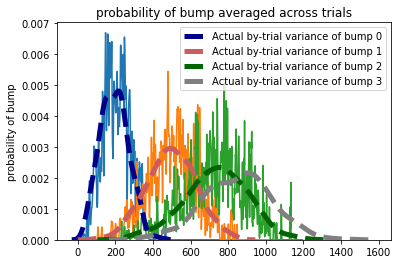

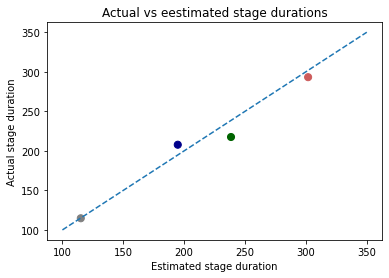

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


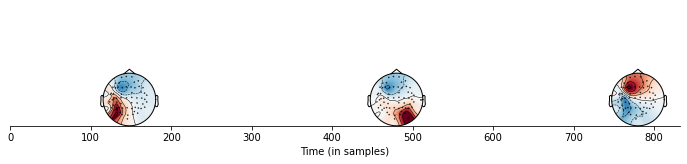

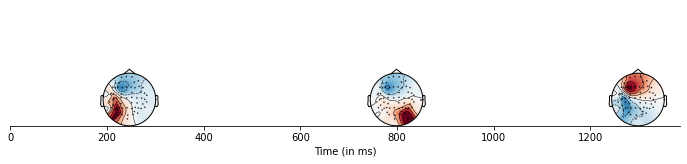

In [5]:
estimates = init.fit_single(3)

plt.plot(estimates.eventprobs.mean(dim=['trial']));
colors = ['darkblue','indianred','darkgreen','grey']
for i in range(len(random_source_times.T)):
    sns.kdeplot(np.sum(random_source_times[:,:i+1],axis=1),lw=5, color=colors[i]
                ,ls='--',label=f'Actual by-trial variance of bump {i}')
plt.legend()
plt.title('probability of bump averaged across trials')
plt.ylabel('probability of bump')
plt.show()


plt.scatter(np.mean(random_source_times, axis=0), estimates.parameters.dropna('stage').isel(params=1)*2, color=colors,s=50)
plt.plot([100,350], [100,350],'--');
plt.title('Actual vs eestimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()

hsmm.plot_topo_timecourse(init, hsmm_dat, estimates, raw, magnify=5)
hsmm.plot_topo_timecourse(init, hsmm_dat, estimates, raw, time=True,magnify=5)

## Iterative estimates

### Forward method

In [6]:
import multiprocessing

cpus = multiprocessing.cpu_count()

with multiprocessing.Pool(processes=cpus) as pool:
    iterative_results = pool.map(init.fit_single, np.arange(1,init.max_bumps+1))
iterative_results = xr.concat(iterative_results,  pd.Series(np.arange(1,init.max_bumps+1), name='n_bumps'))


Estimating parameters for 1 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:398: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:404: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 2 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:398: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:404: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 3 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:398: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:404: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 4 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:398: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:404: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 5 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:398: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:404: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 6 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:398: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:404: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 7 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:398: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:404: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 8 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:398: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:404: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 1 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 8 bumps model


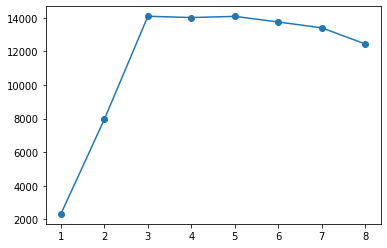

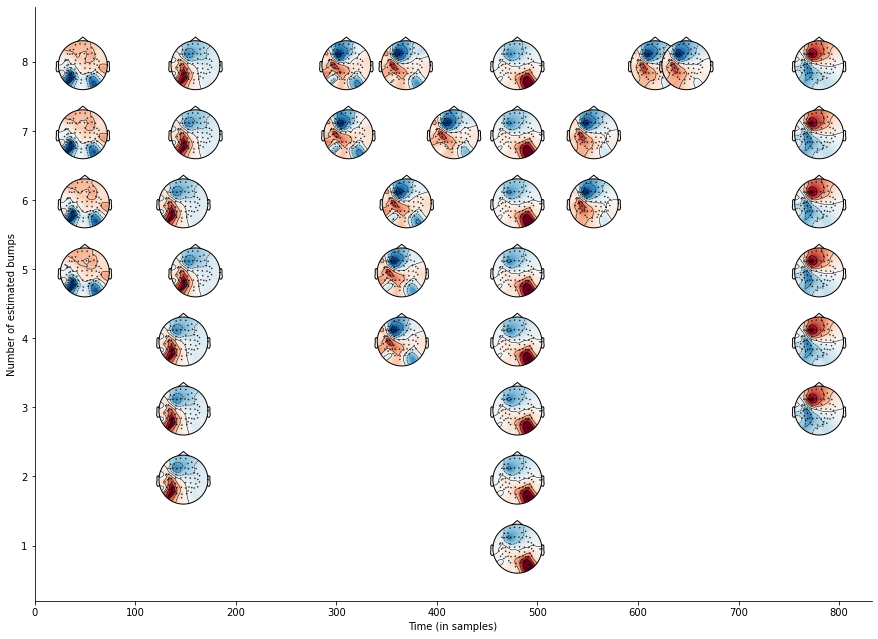

In [7]:
plt.plot(np.arange(1,init.max_bumps+1), iterative_results.likelihoods,'o-')
plt.show()

hsmm.plot_topo_timecourse(init, hsmm_dat, iterative_results, raw, magnify=2, figsize=(15,10))

### Backward method

In [8]:
import itertools
bump_loo_results = [iterative_results.sel(n_bumps=init.max_bumps)]

i = 1
for n_bumps in np.arange(init.max_bumps-1,0,-1):
    temp_best = bump_loo_results[-i]
    n_bumps_list = np.arange(n_bumps+1)
    possible_bumps = np.array(list(itertools.combinations(n_bumps_list, n_bumps)))
    possible_flats = [x + 1 for x in possible_bumps]
    possible_flats = [np.insert(x,0,0) for x in possible_flats]
    with multiprocessing.Pool(processes=cpus) as pool:
        bump_loo_likelihood_temp = pool.starmap(init.fit_single, 
            zip(itertools.repeat(n_bumps),temp_best.magnitudes.values.T[possible_bumps,:],
                temp_best.parameters.values[possible_flats,:],
                itertools.repeat(1),itertools.repeat(True)))
    models = xr.concat(bump_loo_likelihood_temp, dim="iteration")
    bump_loo_results.append(models.sel(iteration=[np.where(models.likelihoods == models.likelihoods.max())[0][0]]))
    i+=1
bests = xr.concat(bump_loo_results, dim="n_bumps")
bests = bests.assign_coords({"n_bumps": np.arange(init.max_bumps,0,-1)})
bests = bests.squeeze('iteration')
bests


Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 6 bumps model
Parameters

<xarray.Dataset>
Dimensions:      (n_bumps: 8, stage: 9, params: 2, component: 10, bump: 8,
                  samples: 1195, trial: 489)
Coordinates:
  * n_bumps      (n_bumps) int64 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 1.244e+04 1.35e+04 ... 7.964e+03 2.033e+03
    parameters   (n_bumps, stage, params) float64 2.0 41.39 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 0.04202 -1.839 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

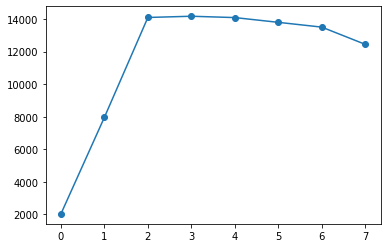

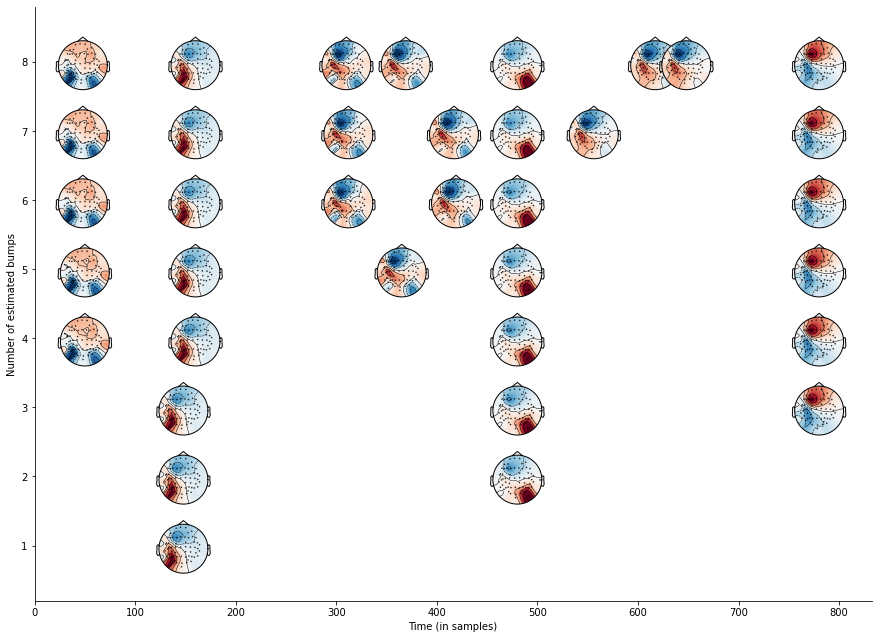

In [12]:
plt.plot(np.arange(init.max_bumps), bests.likelihoods[::-1],'o-')
plt.show()

hsmm.plot_topo_timecourse(init, hsmm_dat, bests, raw, magnify=2, figsize=(15,10))